In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def generate_synthetic_data(hours=10000):
    base_temp = 22
    base_humidity = 65
    crops = ['wheat', 'rice', 'maize', 'barley', 'oats', 'sorghum']
    
    data = []
    timestamp = datetime(2025, 1, 1, 0, 0)
    
    for i in range(hours):
        # Diurnal cycle (hourly variation)
        hour = i % 24
        diurnal_temp = 3 * np.sin(2 * np.pi * hour / 24)  # ±3°C daily swing
        diurnal_humidity = 5 * np.sin(2 * np.pi * hour / 24 + np.pi/4)  # ±5% humidity swing
        
        # Seasonal trend (over 416 days)
        day = i // 24
        seasonal_temp = 2 * np.sin(2 * np.pi * day / 365)  # ±2°C annual swing
        seasonal_humidity = 3 * np.sin(2 * np.pi * day / 365 + np.pi/2)  # ±3% humidity swing
        
        crop = np.random.choice(crops)
        # Base values with diurnal and seasonal variations
        temp = np.clip(base_temp + diurnal_temp + seasonal_temp + np.random.normal(0, 1), 15, 30)
        humidity = np.clip(base_humidity + diurnal_humidity + seasonal_humidity + np.random.normal(0, 2), 50, 90)
        
        # Moisture calculation with crop-specific adjustment
        moisture = 0.15 * humidity + 2.5
        if crop == 'rice':
            moisture += 1
        elif crop in ['maize', 'sorghum']:
            moisture += 0.5
        elif crop in ['barley', 'oats']:
            moisture += 0.2
        
        # Add crop-specific noise and random spikes
        noise_scale = 0.3 if crop in ['wheat', 'barley', 'oats'] else 0.4  # Slightly higher noise for rice, maize, sorghum
        moisture += np.random.normal(0, noise_scale)
        
        # Random spike (5% chance per day)
        if np.random.random() < 0.05 / 24:  # 5% chance per hour
            temp += np.random.uniform(2, 5)  # Temperature spike
            humidity += np.random.uniform(5, 10)  # Humidity spike
            moisture += np.random.uniform(0.5, 1.5)  # Moisture spike
        
        moisture = np.clip(moisture, 10, 18)
        
        data.append([timestamp, crop, temp, humidity, moisture])
        timestamp += timedelta(hours=1)

    return pd.DataFrame(data, columns=['timestamp', 'crop', 'temperature_c', 'humidity_percent', 'grain_moisture_percent'])

# Generate and save the dataset
df = generate_synthetic_data()
df.to_csv("grain_lstm_dataset_10000_realistic.csv", index=False)  # Updated filename
print(f"Dataset with {len(df)} entries generated from {df['timestamp'].min()} to {df['timestamp'].max()}.")

Dataset with 10000 entries generated from 2025-01-01 00:00:00 to 2026-02-21 15:00:00.


In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/kaggle/working/grain_lstm_dataset_10000.csv')
print(f"Dataset loaded with {len(df)} entries from {df['timestamp'].min()} to {df['timestamp'].max()}.")

Dataset loaded with 10000 entries from 2025-01-01 00:00:00 to 2026-02-21 15:00:00.


In [23]:
df.columns

Index(['timestamp', 'crop', 'temperature_c', 'humidity_percent',
       'grain_moisture_percent'],
      dtype='object')

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Load the dataset (assuming it's already generated, e.g., grain_lstm_dataset_20000.csv)
# df = pd.read_csv('grain_lstm_dataset_20000.csv')  # Uncomment and adjust path if needed

# Prepare the data
# Use crop, temperature, and humidity as features, predict moisture
# First, separate the crop column for one-hot encoding
crops = df['crop'].values.reshape(-1, 1)
features_raw = df[['temperature_c', 'humidity_percent']].values

# Apply one-hot encoding to crops
encoder = OneHotEncoder(sparse=False, categories='auto')
crops_encoded = encoder.fit_transform(crops)

# Combine encoded crops with temperature and humidity
features = np.hstack((crops_encoded, features_raw))

target = df['grain_moisture_percent'].values

# Normalize the data
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.reshape(-1, 1))

# Optional: Print shapes to verify
print(f"Features shape: {features_scaled.shape}")  # Should be (20000, 8) with 6 crops + 2 features
print(f"Target shape: {target_scaled.shape}")  # Should be (20000, 1)

Features shape: (10000, 8)
Target shape: (10000, 1)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 0.0384 - val_loss: 0.0131
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0116 - val_loss: 0.0109
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0113 - val_loss: 0.0105
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0105 - val_loss: 0.0114
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0104 - val_loss: 0.0104
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0104 - val_loss: 0.0108
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0106 - val_loss: 0.0108
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0105 - val_loss: 0.0107
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.0106 - val_loss: 0.0111
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0101 - val_loss: 0.0113
Epoch 12/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/st

/tmp/ipykernel_35/1970419461.py:89: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_timestamps = pd.date_range(start=last_timestamp + timedelta(hours=1), periods=168, freq='H')


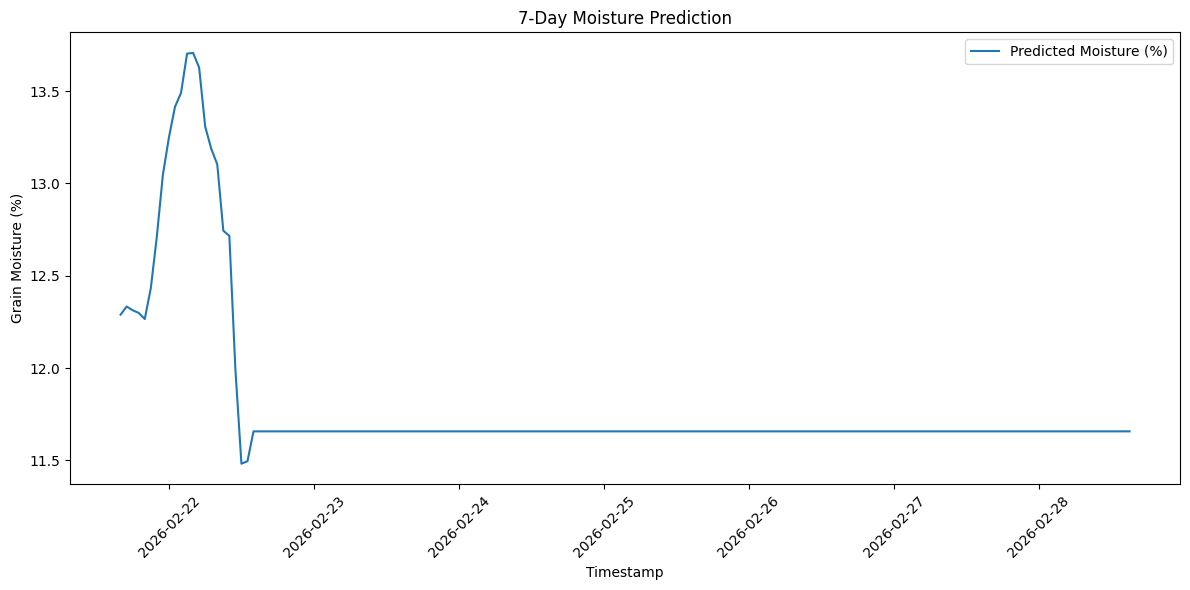


7-Day Moisture Predictions:
2026-02-21 16:00:00: 12.3%
2026-02-21 17:00:00: 12.3%
2026-02-21 18:00:00: 12.3%
2026-02-21 19:00:00: 12.3%
2026-02-21 20:00:00: 12.3%
2026-02-21 21:00:00: 12.4%
2026-02-21 22:00:00: 12.7%
2026-02-21 23:00:00: 13.0%
2026-02-22 00:00:00: 13.2%
2026-02-22 01:00:00: 13.4%
2026-02-22 02:00:00: 13.5%
2026-02-22 03:00:00: 13.7%
2026-02-22 04:00:00: 13.7%
2026-02-22 05:00:00: 13.6%
2026-02-22 06:00:00: 13.3%
2026-02-22 07:00:00: 13.2%
2026-02-22 08:00:00: 13.1%
2026-02-22 09:00:00: 12.7%
2026-02-22 10:00:00: 12.7%
2026-02-22 11:00:00: 12.0%
2026-02-22 12:00:00: 11.5%
2026-02-22 13:00:00: 11.5%
2026-02-22 14:00:00: 11.7%
2026-02-22 15:00:00: 11.7%
2026-02-22 16:00:00: 11.7%
2026-02-22 17:00:00: 11.7%
2026-02-22 18:00:00: 11.7%
2026-02-22 19:00:00: 11.7%
2026-02-22 20:00:00: 11.7%
2026-02-22 21:00:00: 11.7%
2026-02-22 22:00:00: 11.7%
2026-02-22 23:00:00: 11.7%
2026-02-23 00:00:00: 11.7%
2026-02-23 01:00:00: 11.7%
2026-02-23 02:00:00: 11.7%
2026-02-23 03:00:00: 11.7%

In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Load the dataset (adjust path as needed)
df = pd.read_csv('/kaggle/working/grain_lstm_dataset_10000_realistic.csv')  # Uncomment and adjust if needed

# Prepare the data with one-hot encoding for crops
crops = df['crop'].values.reshape(-1, 1)
features_raw = df[['temperature_c', 'humidity_percent']].values
encoder = OneHotEncoder(sparse=False, categories='auto')
crops_encoded = encoder.fit_transform(crops)
features = np.hstack((crops_encoded, features_raw))
target = df['grain_moisture_percent'].values

# Normalize the data
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.reshape(-1, 1))

# Create sequences
def create_sequences(X, y, seq_length=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 24
X, y = create_sequences(features_scaled, target_scaled, seq_length)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, 8), return_sequences=True),  # 8 features
    LSTM(100, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, verbose=1)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Function to predict future moisture for 7 days (168 hours)
def predict_7_days(last_sequence, last_temp, last_humidity, crop, steps=168, encoder=encoder, scaler_features=scaler_features, scaler_target=scaler_target, model=model):
    # One-hot encode the crop
    crop_encoded = encoder.transform([[crop]])[0]
    # Combine with the last temperature and humidity
    last_input = np.hstack([crop_encoded, [last_temp, last_humidity]])  # 6 + 2 = 8 columns
    # Normalize the input
    last_input_scaled = scaler_features.transform([last_input])[0]
    # Initialize sequence with the last 24 hours, updating the last step
    current_sequence = np.vstack([last_sequence[1:], last_input_scaled.reshape(1, -1)])  # Shape: (24, 8)

    future_preds = []
    for _ in range(steps):
        next_pred_scaled = model.predict(current_sequence[np.newaxis, :, :], verbose=0)
        next_pred = scaler_target.inverse_transform(next_pred_scaled)[0][0]
        future_preds.append(next_pred)
        # Update sequence with the latest input
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1, :] = scaler_features.transform([np.hstack([crop_encoded, [last_temp, last_humidity]])])[0]  # Update all 8 columns

    return np.array(future_preds)

# Predict for 7 days using the last sequence
last_sequence = features_scaled[-seq_length:]  # Last 24 hours
last_crop = df['crop'].iloc[-1]  # Last crop in the dataset
last_temp = df['temperature_c'].iloc[-1]  # Last temperature
last_humidity = df['humidity_percent'].iloc[-1]  # Last humidity
future_moisture = predict_7_days(last_sequence, last_temp, last_humidity, last_crop, steps=168)

# Generate future timestamps
last_timestamp = pd.to_datetime(df['timestamp'].iloc[-1])
future_timestamps = pd.date_range(start=last_timestamp + timedelta(hours=1), periods=168, freq='H')

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_timestamps, future_moisture, label='Predicted Moisture (%)')
plt.title('7-Day Moisture Prediction')
plt.xlabel('Timestamp')
plt.ylabel('Grain Moisture (%)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Print predictions
print("\n7-Day Moisture Predictions:")
for ts, moist in zip(future_timestamps, future_moisture):
    print(f"{ts}: {moist:.1f}%")

In [44]:
model.save('lstm_moisture_model_new_augmented.h5')

In [41]:
# Store the 7th day prediction (168th hour)
seventh_day_timestamp = future_timestamps[-1]
seventh_day_moisture = future_moisture[-1]
print(f"7th Day Prediction ({seventh_day_timestamp}): {seventh_day_moisture:.1f}%")

7th Day Prediction (2026-02-28 15:00:00): 11.7%


In [27]:
# Split into train and test sets (preserve time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

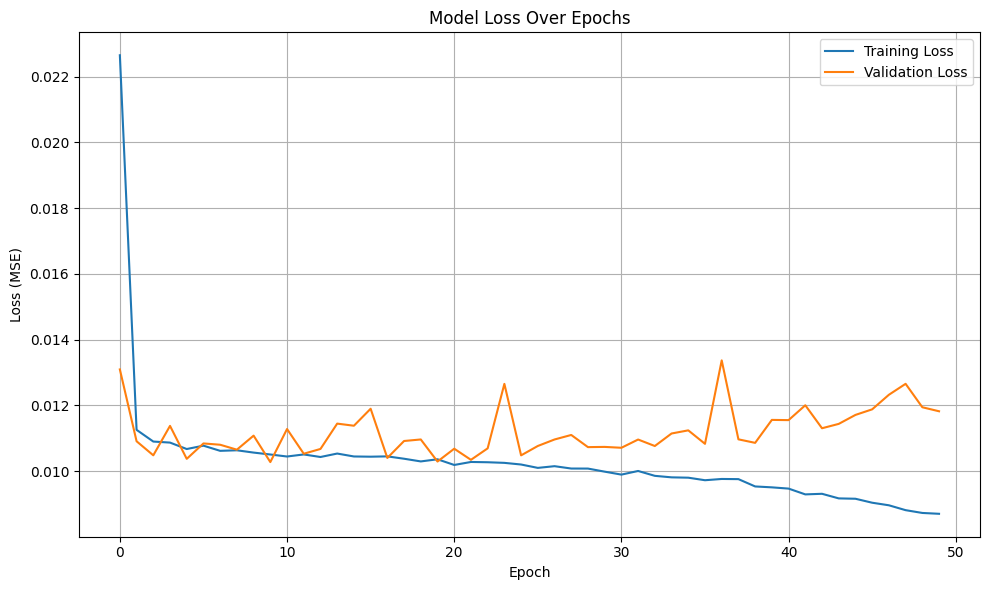

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
!pip install serial

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.2 MB/s eta 0:00:00


In [16]:
import serial
import time
from datetime import datetime
import sys

# Baseline parameters and weights
base_params = {
    'wheat':   {'temp': 22, 'humidity': 60, 'moisture': 11.8},
    'rice':    {'temp': 23, 'humidity': 65, 'moisture': 12.8},
    'maize':   {'temp': 22.5, 'humidity': 62, 'moisture': 12.5},
    'barley':  {'temp': 22, 'humidity': 60, 'moisture': 11.8},
    'sorghum': {'temp': 22.5, 'humidity': 62, 'moisture': 12.5},
    'oats':    {'temp': 22, 'humidity': 60, 'moisture': 11.8}
}
weights = {'temp': 0.3, 'humidity': 0.4, 'moisture': 0.3}

# Function to calculate dynamic deviation score
def calculate_deviation_score(temp, humidity, moisture, crop):
    base = base_params.get(crop, base_params['wheat'])
    temp_dev = abs(temp - base['temp']) / base['temp'] if base['temp'] != 0 else 0
    hum_dev = abs(humidity - base['humidity']) / base['humidity'] if base['humidity'] != 0 else 0
    moist_dev = abs(moisture - base['moisture']) / base['moisture'] if base['moisture'] != 0 else 0
    score = (weights['temp'] * temp_dev) + (weights['humidity'] * hum_dev) + (weights['moisture'] * moist_dev)
    return score

# Function to determine dynamic threshold and aeration need
def check_aeration(temp, humidity, moisture, crop):
    score = calculate_deviation_score(temp, humidity, moisture, crop)
    
    # Adjust threshold based on moisture level
    base_threshold = 0.2
    if moisture < 10:
        threshold = base_threshold + 0.05  # Less urgency if moisture is very low
    elif moisture > 15:
        threshold = base_threshold - 0.05  # More urgency if moisture is very high
    else:
        threshold = base_threshold
    
    base = base_params.get(crop, base_params['wheat'])
    if score > threshold:
        return (f"Aerate {crop} storage: Score={score:.2f} (exceeds threshold {threshold:.2f}), "
                f"Temp={temp}°C (base {base['temp']}°C), Humidity={humidity}% (base {base['humidity']}%), "
                f"Moisture={moisture}% (base {base['moisture']}%)")
    return (f"No aeration needed for {crop}: Score={score:.2f} (below threshold {threshold:.2f}), "
            f"Temp={temp}°C (base {base['temp']}°C), Humidity={humidity}% (base {base['humidity']}%), "
            f"Moisture={moisture}% (base {base['moisture']}%)")

# Function to get data from hardware (simulated with manual input; replace with actual method)
def get_hardware_data():
    try:
        crop = input("Enter crop (e.g., wheat): ") or 'wheat'
        temp = float(input(f"Enter temperature (°C) for {crop}: ") or 20.0)
        humidity = float(input(f"Enter humidity (%) for {crop}: ") or 60.0)
        moisture = float(input(f"Enter moisture (%) for {crop}: ") or 11.5)
        return crop, temp, humidity, moisture
    except ValueError:
        print("Invalid input. Please enter numeric values.")
        return get_hardware_data()

# Main monitoring loop
def monitor_storage():
    print(f"Monitoring started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} IST")
    log_file = 'aeration_log_dynamic.txt'

    while True:
        try:
            # Get data from hardware
            crop, temp, humidity, moisture = get_hardware_data()

            # Check aeration need with dynamic threshold
            decision = check_aeration(temp, humidity, moisture, crop)

            # Display and log the decision
            print(f"\n{decision}")
            with open(log_file, 'a') as f:
                f.write(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} IST - {decision}\n")

            # Wait for next reading (e.g., every 1 hour or based on hardware interval)
            time.sleep(3600)  # 1 hour; adjust based on hardware update rate

        except KeyboardInterrupt:
            print("\nMonitoring stopped.")
            break
        except Exception as e:
            print(f"Error: {e}")
            time.sleep(60)  # Wait before retrying on error

if __name__ == "__main__":
    monitor_storage()

Monitoring started at 2025-06-26 17:02:06 IST


Enter crop (e.g., wheat):  wheat
Enter temperature (°C) for wheat:  24
Enter humidity (%) for wheat:  60
Enter moisture (%) for wheat:  30



Aerate wheat storage: Score=0.56 (exceeds threshold 0.15), Temp=24.0°C (base 18°C), Humidity=60.0% (base 60%), Moisture=30.0% (base 11.8%)

Monitoring stopped.


In [45]:
import time
from datetime import datetime

# Baseline parameters and weights
base_params = {
    'wheat':   {'temp': 22, 'humidity': 60, 'moisture': 11.8},
    'rice':    {'temp': 23, 'humidity': 65, 'moisture': 12.8},
    'maize':   {'temp': 22.5, 'humidity': 62, 'moisture': 12.5},
    'barley':  {'temp': 22, 'humidity': 60, 'moisture': 11.8},
    'sorghum': {'temp': 22.5, 'humidity': 62, 'moisture': 12.5},
    'oats':    {'temp': 22, 'humidity': 60, 'moisture': 11.8}
}
weights = {'temp': 0.3, 'humidity': 0.4, 'moisture': 0.3}

# Calculate deviation score
def calculate_deviation_score(temp, humidity, moisture, crop):
    base = base_params.get(crop, base_params['wheat'])
    temp_dev = abs(temp - base['temp']) / base['temp']
    hum_dev = abs(humidity - base['humidity']) / base['humidity']
    moist_dev = abs(moisture - base['moisture']) / base['moisture']
    score = (weights['temp'] * temp_dev +
             weights['humidity'] * hum_dev +
             weights['moisture'] * moist_dev)
    return round(score, 4)

# Dynamic aeration recommendation
def check_aeration(temp, humidity, moisture, crop):
    score = calculate_deviation_score(temp, humidity, moisture, crop)
    
    base_threshold = 0.2
    if moisture < 10:
        threshold = base_threshold + 0.05
    elif moisture > 15:
        threshold = base_threshold - 0.05
    else:
        threshold = base_threshold

    base = base_params[crop]
    if score > threshold:
        return (f"Aerate {crop} storage: Score={score:.2f} (exceeds threshold {threshold:.2f}), "
                f"Temp={temp}°C (base {base['temp']}°C), Humidity={humidity}% (base {base['humidity']}%), "
                f"Moisture={moisture}% (base {base['moisture']}%)"), score
    return (f"No aeration needed for {crop}: Score={score:.2f} (below threshold {threshold:.2f}), "
            f"Temp={temp}°C (base {base['temp']}°C), Humidity={humidity}% (base {base['humidity']}%), "
            f"Moisture={moisture}% (base {base['moisture']}%)"), score

# Spoilage classification
def classify_spoilage_level(score, moisture, crop):
    moist_thresh = base_params[crop]['moisture']
    if score < 0.15 and moisture <= moist_thresh:
        return 'none'
    elif score < 0.25:
        return 'low'
    elif score < 0.40 or moisture <= 15:
        return 'moderate'
    else:
        return 'high'

# Wastage estimation and waste pathway recommendation
def calculate_wastage_and_pathway(spoilage_level, moisture, storage_tons=100, hours_exposed=24):
    base_spoilage = {
        'none': 0,
        'low': 5,
        'moderate': 25,
        'high': 50
    }[spoilage_level]

    factor = 1 + min(hours_exposed / 24, 3)
    spoilage_pct = min(base_spoilage * factor, 100)
    wasted_tons = round(storage_tons * spoilage_pct / 100, 2)

    if spoilage_level == 'none':
        pathway = 'retain'
    elif spoilage_level == 'low' and moisture <= 13:
        pathway = 'animal feed'
    elif spoilage_level == 'moderate':
        pathway = 'compost'
    else:
        pathway = 'biofuel'

    return round(spoilage_pct, 2), wasted_tons, pathway

# Get user input (replace with serial read in deployment)
def get_hardware_data():
    try:
        crop = input("Enter crop (e.g., wheat): ") or 'wheat'
        temp = float(input(f"Enter temperature (°C) for {crop}: ") or 20.0)
        humidity = float(input(f"Enter humidity (%) for {crop}: ") or 60.0)
        moisture = float(input(f"Enter moisture (%) for {crop}: ") or 11.5)
        return crop, temp, humidity, moisture
    except ValueError:
        print("Invalid input. Please enter numeric values.")
        return get_hardware_data()

# Main monitoring loop
def monitor_storage():
    print(f"🔍 Monitoring started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} IST")
    log_file = 'aeration_log_dynamic.txt'

    while True:
        try:
            # Get data
            crop, temp, humidity, moisture = get_hardware_data()

            # Aeration check
            decision, score = check_aeration(temp, humidity, moisture, crop)
            print(f"\n🌾 {decision}")

            # Spoilage + Waste Management
            spoilage_level = classify_spoilage_level(score, moisture, crop)
            spoilage_pct, wasted_tons, pathway = calculate_wastage_and_pathway(
                spoilage_level, moisture, storage_tons=100, hours_exposed=24
            )

            # Display
            print(f"🧪 Spoilage Level: {spoilage_level}")
            print(f"📉 Estimated Wastage: {spoilage_pct:.1f}% (~{wasted_tons} tons)")
            print(f"♻️ Suggested Pathway: {pathway.upper()}")

            # Logging
            with open(log_file, 'a') as f:
                f.write(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - {decision} | "
                        f"Spoilage: {spoilage_level}, Wastage: {wasted_tons} tons, Pathway: {pathway}\n")

            # Wait before next check
            time.sleep(3600)  # every hour

        except KeyboardInterrupt:
            print("\n🛑 Monitoring stopped.")
            break
        except Exception as e:
            print(f"❌ Error: {e}")
            time.sleep(60)

if __name__ == "__main__":
    monitor_storage()


🔍 Monitoring started at 2025-06-26 18:28:50 IST


Enter crop (e.g., wheat):  wheat
Enter temperature (°C) for wheat:  20
Enter humidity (%) for wheat:  56
Enter moisture (%) for wheat:  23



🌾 Aerate wheat storage: Score=0.34 (exceeds threshold 0.15), Temp=20.0°C (base 22°C), Humidity=56.0% (base 60%), Moisture=23.0% (base 11.8%)
🧪 Spoilage Level: moderate
📉 Estimated Wastage: 50.0% (~50.0 tons)
♻️ Suggested Pathway: COMPOST

🛑 Monitoring stopped.


In [11]:
# Crop thresholds (indoor adjusted)
base_params = {
    'wheat': {'moisture': 11.8},
    'rice': {'moisture': 12.8},
    'maize': {'moisture': 12.5},
    'barley': {'moisture': 11.8},
    'sorghum': {'moisture': 12.5},
    'oats': {'moisture': 11.8}
}

spoilage_thresholds = {
    'wheat':   {'none': 11.8, 'low': 12.4, 'moderate': 13.0},
    'rice':    {'none': 12.8, 'low': 13.5, 'moderate': 14.2},
    'maize':   {'none': 12.5, 'low': 13.2, 'moderate': 14.0},
    'barley':  {'none': 11.8, 'low': 12.5, 'moderate': 13.1},
    'sorghum': {'none': 12.5, 'low': 13.0, 'moderate': 13.8},
    'oats':    {'none': 11.8, 'low': 12.4, 'moderate': 13.0}
}


# Classify spoilage from predicted 7th-day moisture
def classify_spoilage(moisture, crop):
    if crop not in spoilage_thresholds:
        raise ValueError(f"Crop '{crop}' not found in spoilage thresholds.")
    
    th = spoilage_thresholds[crop]
    
    if moisture <= th['none']:
        return 'none'
    elif moisture <= th['low']:
        return 'low'
    elif moisture <= th['moderate']:
        return 'moderate'
    else:
        return 'high'


# Estimate wastage and pathway
def estimate_waste(moisture_day7, crop, total_production_tons, hours_exposed=168):
    spoilage_level = classify_spoilage(moisture_day7, crop)
    
    base_spoilage = {
        'none': 0,
        'low': 5,
        'moderate': 25,
        'high': 50
    }[spoilage_level]
    
    time_factor = 1 + min(hours_exposed / 24, 3)  # cap at 4x
    spoilage_pct = min(base_spoilage * time_factor, 100)
    wasted_tons = round(total_production_tons * spoilage_pct / 100, 2)

    # Recommend pathway
    if spoilage_level == 'none':
        pathway = 'retain'
    elif spoilage_level == 'low' and moisture_day7 <= 13:
        pathway = 'animal feed'
    elif spoilage_level == 'moderate':
        pathway = 'compost'
    else:
        pathway = 'biofuel'

    return {
        "crop": crop,
        "predicted_moisture_day7": moisture_day7,
        "spoilage_level": spoilage_level,
        "spoilage_percent": spoilage_pct,
        "wasted_tons": wasted_tons,
        "recommended_pathway": pathway
    }

# --------- User Input Section ----------
try:
    crop = input("Enter crop (e.g., wheat): ").strip().lower()
    if crop not in base_params:
        raise ValueError("Crop not supported.")
    
    moisture_day7 = float(input("Enter predicted moisture on Day 7 (%): "))
    total_production_tons = float(input("Enter total production in tons: "))

    result = estimate_waste(moisture_day7, crop, total_production_tons)

    print("\n📊 Waste Management Decision for Day 7:")
    for k, v in result.items():
        print(f"{k.replace('_', ' ').capitalize()}: {v}")

except ValueError as e:
    print(f"❌ Input error: {e}")


Enter crop (e.g., wheat):  wheat
Enter predicted moisture on Day 7 (%):  34
Enter total production in tons:  25



📊 Waste Management Decision for Day 7:
Crop: wheat
Predicted moisture day7: 34.0
Spoilage level: high
Spoilage percent: 100
Wasted tons: 25.0
Recommended pathway: biofuel


In [2]:
!pip install serial

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.6 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import serial  # For hardware simulation; replace with your library (e.g., paho.mqtt for MQTT)

# Load the dataset (adjust path as needed)
df = pd.read_csv('/kaggle/working/grain_lstm_dataset_10000_realistic.csv')

# Prepare the data with one-hot encoding for crops
crops = df['crop'].values.reshape(-1, 1)
features_raw = df[['temperature_c', 'humidity_percent']].values
encoder = OneHotEncoder(sparse=False, categories='auto')
crops_encoded = encoder.fit_transform(crops)
features = np.hstack((crops_encoded, features_raw))
target = df['grain_moisture_percent'].values

# Normalize the data
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.reshape(-1, 1))

# Create sequences
def create_sequences(X, y, seq_length=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 24
X, y = create_sequences(features_scaled, target_scaled, seq_length)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, 8), return_sequences=True),  # 8 features
    LSTM(100, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, verbose=1)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Function to get real-time data from hardware (customize based on your setup)
def get_hardware_data():
    try:
        # Example: Simulate hardware input (replace with actual hardware read)
        # For serial: ser = serial.Serial('COM3', 9600); line = ser.readline().decode().strip().split(',')
        # For MQTT: Use paho.mqtt.client to subscribe and parse
        crop = input("Enter crop (e.g., wheat): ") or 'wheat'
        temp = float(input(f"Enter current temperature (°C) for {crop}: ") or 22.0)
        humidity = float(input(f"Enter current humidity (%) for {crop}: ") or 65.0)
        return crop, temp, humidity
    except ValueError:
        print("Invalid input. Please enter numeric values.")
        return get_hardware_data()

# Function to predict 7th day moisture with real-time data
def predict_7th_day(last_sequence, real_time_data, steps=168, encoder=encoder, scaler_features=scaler_features, scaler_target=scaler_target, model=model):
    crop, temp, humidity = real_time_data
    crop_encoded = encoder.transform([[crop]])[0]
    last_input = np.hstack([crop_encoded, [temp, humidity]])
    last_input_scaled = scaler_features.transform([last_input])[0]
    current_sequence = np.vstack([last_sequence[1:], last_input_scaled.reshape(1, -1)])  # Shape: (24, 8)

    for _ in range(steps - 1):  # Predict up to 167 steps, save the 168th
        next_pred_scaled = model.predict(current_sequence[np.newaxis, :, :], verbose=0)
        next_pred = scaler_target.inverse_transform(next_pred_scaled)[0][0]
        # Update sequence with current temp and humidity
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1, :] = scaler_features.transform([np.hstack([crop_encoded, [temp, humidity]])])[0]

    # Final prediction for the 168th hour (7th day)
    final_pred_scaled = model.predict(current_sequence[np.newaxis, :, :], verbose=0)
    final_pred = scaler_target.inverse_transform(final_pred_scaled)[0][0]
    return final_pred

# Get real-time data and predict 7th day moisture
real_time_data = get_hardware_data()
last_sequence = features_scaled[-seq_length:]  # Last 24 hours from dataset
seventh_day_moisture = predict_7th_day(last_sequence, real_time_data)

# Generate the 7th day timestamp
last_timestamp = pd.to_datetime(df['timestamp'].iloc[-1])
seventh_day_timestamp = last_timestamp + timedelta(hours=168)

# Print only the 7th day prediction
print(f"7th Day Prediction ({seventh_day_timestamp} IST): {seventh_day_moisture:.1f}%")

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
2025-06-27 00:57:42.138430: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - loss: 0.0310 - val_loss: 0.0118
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0115 - val_loss: 0.0104
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0112 - val_loss: 0.0114
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0112 - val_loss: 0.0106
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0104 - val_loss: 0.0134
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0110 - val_loss: 0.0118
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0105 - val_loss: 0.0102
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0108 - val_loss: 0.0101
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0104 - val_loss: 0.0106
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 12/50
200/200 ━━━━━━━━━━━━━━━━━━━━

Enter crop (e.g., wheat):  wheat
Enter current temperature (°C) for wheat:  20.5
Enter current humidity (%) for wheat:  36


7th Day Prediction (2026-02-28 15:00:00 IST): 21.2%


In [6]:
model.save('lstm_moisture_model_7th_day.h5')

In [8]:
# app/preprocessing.py
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import numpy as np
import joblib

# 1. Crop categories (as in training)
crop_categories = [['wheat', 'rice', 'maize', 'barley', 'soybean', 'sorghum']]

# 2. Rebuild encoder
encoder = OneHotEncoder(sparse=False, categories=crop_categories)
encoder.fit([['wheat'], ['rice'], ['maize'], ['barley'], ['soybean'], ['sorghum']])
joblib.dump(encoder, '/kaggle/working/encoder.pkl')

# 3. Dummy data to fit scalers (simulate training normalization)
X_dummy = []
for crop in crop_categories[0]:
    for temp in range(10, 41, 10):  # temp: 10°C to 40°C
        for hum in range(20, 101, 40):  # hum: 20% to 100%
            encoded = encoder.transform([[crop]])[0]
            X_dummy.append(np.hstack([encoded, [temp, hum]]))
X_dummy = np.array(X_dummy)

scaler_features = MinMaxScaler()
scaler_features.fit(X_dummy)
joblib.dump(scaler_features, '/kaggle/working/scaler_features.pkl')

scaler_target = MinMaxScaler()
scaler_target.fit(np.array([[5], [25]]))  # Target values: min 5%, max 25% (adjust as per your model)
joblib.dump(scaler_target, '/kaggle/working/scaler_target.pkl')

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['/kaggle/working/scaler_target.pkl']